In [5]:
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer
from PIL import Image
import requests
import torch 
from tqdm import tqdm
import json

model = AutoModelForCausalLM.from_pretrained(
    "anananan116/TinyVLM",
    trust_remote_code = True,
    torch_dtype=torch.float16,
    ).to('cuda').eval()
tokenizer = AutoTokenizer.from_pretrained("anananan116/TinyVLM")
ds = load_dataset("darkyarding/MME")
device = torch.device('cuda')

Some weights of AtriVLM were not initialized from the model checkpoint at anananan116/TinyVLM and are newly initialized: ['visual.text_projection.weight', 'visual.visual_projection.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class Collator:
    def __init__(self):
        """
        Initialize the collator with any necessary parameters
        """
        pass
        
    def __call__(self, batch):
        """
        Collate a batch of samples into a format suitable for the model
        
        Args:
            batch: List of dictionaries containing the samples
            
        Returns:
            Dictionary with batched data
        """
        # Initialize lists to store batch items
        question_ids = []
        images = []
        questions = []
        answers = []
        categories = []
        
        # Collect items from the batch
        for item in batch:
            question_ids.append(item['question_id'])
            images.append(item['image'])
            questions.append(item['question'])
            answers.append(item['answer'])
            categories.append(item['category'])
            
        # Create the batched dictionary
        batched = {
            'question_id': question_ids,
            'image': images,  # Keep as list of PIL images
            'question': questions,
            'answer': answers,
            'category': categories
        }
        
        return batched

In [ ]:
answers = []
dataloader = DataLoader(ds['test'], batch_size=16, shuffle=False, collate_fn=Collator())
with torch.no_grad():
    for batch in tqdm(dataloader):
        images = batch['image']
        prompts = ["<IMGPLH>" + x for x in batch['question']]
        question_ids = batch['question_id']
        inputs = model.prepare_input_ids_for_generation(prompts, images, tokenizer)
        outputs = model.generate(
            input_ids=inputs['input_ids'].to(device), 
            attention_mask=inputs['attention_mask'].to(device), 
            encoded_image = inputs["encoded_image"], 
            max_new_tokens=128, 
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            top_p=0.9,
            temperature = 0.8
        )
        output_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        output_text = [text.split("assistant\n\n")[1] for text in output_text]
        for qid, ans, q, gt in zip(question_ids, output_text, batch['question'], batch['answer']):
            answers.append((qid, q, gt, ans))

In [ ]:
with open("results/answers.json", "w") as f:
    json.dump(answers, f)

In [6]:
Questions = {
    'i1.png':'What is the woman doing?',
    'i2.png':'What is the utensil present?',
    'i3.png':'How many flower pots are there that have blue flowers?',
    'i4.png':'What color is the bridge if someone painted it green?',
    'i5.png':'What is the number on the helmet?',
    'i6.png':'How many seeds should I expect from this apple?',
    'i7.png':'Where does this come from and which country is next to it?',
    'i8.png':'How many people are on the balcony that are male?',
    'i9.png':'How many blue eyes does the frog have?',
    'i10.png':'What are the colors here?',
    'i11.png':'What will happen if I were to drop it from my roof?',
    'i12.png':'What is the color of the water bottle?',
    'i13.png':'What is the color of the hat the man is wearing?',
    'i14.png':'What is this and what can I do with it?',
    'i15.png':'Where are we right now?',
    'i16.png':'How many orange stars are there if we put an orange star on the bear?',
    'i17.png':'How many pillows are there that are beige?',
    'i18.png':'How long will it take for all of the icecubes to melt?',
    'i19.png':'What are the colors in the image and what will the color be if I combined all of them?',
    'i20.png':'How many bananas are there if I took one away?',
    "3.png": "Is it a fox, a wolf, or something else entirely in the image?",
    "4.jpg": "How many people are not wearing hat?",
    "5.png": "If the mushrooms had eyes, how many could they plausibly have?",
    "66.jpg": "What unexpected combination of ingredients could be inside the hotdog?",
    "9780593649237.jpg": "Is it a fox, a raccoon, or a cleverly disguised object in the image?",
    "artworks-000360728946-bilq7t-t500x500.jpg": "Is it a cow, a person wearing a cow costume, or an abstract representation?",
    "avatars-000508491087-32hktm-t1080x1080.jpg": "Is it chocolate, a person holding chocolate, or something imitating both?",
    "bx108577-plhp2UMSmEhk.jpg": "How many distinct reflections or silhouettes of people can you detect?",
    "depositphotos_35630897-stock-photo-random-chance-luck-gumball-machine.jpg": "What is the most peculiar and colorful object hidden inside the image?",
    "hq720.jpg": "What is the function of the shiny blue object in the image, and why might it be there?",
    "images (1).jpg": "Is it a cow, a man in a cow mask, or an entirely unrelated figure?",
    "images (2).jpg": "What element in the picture defies your initial expectations?",
    "images (3).jpg": "Are there any flags, hidden symbols, or unexpected patterns in the image?",
    "images (4).jpg": "Is it a real dog, a robotic dog, or an illusion of one?",
    "images.jpg": "What unique or hybrid creature could the animal in the image represent?",
    "penguin_random_house_publishing_logo.jpg": "What specific color details or patterns make the penguin's design unique?",
    "Random-Pictures-of-Conceptual-and-Creative-Ideas-02.jpg": "What unusual material or concept could the house be built upon?",
    "rr33-10.jpg": "Is it a human, a distorted face, or a purely optical illusion in the image?",
    "sddefault.jpg": "Based on the image, can you calculate the approximate density of the hair strands?",
    "unnamed.png": "How many hands, partial hands, or objects resembling hands are discernible in the picture?"
}

In [8]:
images = []
questions = []
for k,v in Questions.items():
    images.append(Image.open(f"./assets/test_images/{k}"))
    questions.append(v)

In [15]:
with torch.no_grad():
    prompts = ["<IMGPLH>" + x + "Carefully exlain your reasoning beofer answering the question." for x in questions]
    inputs = model.prepare_input_ids_for_generation(prompts, images, tokenizer)
    outputs = model.generate(
        input_ids=inputs['input_ids'].to(device), 
        attention_mask=inputs['attention_mask'].to(device), 
        encoded_image = inputs["encoded_image"], 
        max_new_tokens=128, 
        do_sample=True,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
        top_p=0.9,
        temperature = 0.8
    )
    output_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    output_text = [text.split("assistant\n\n")[1].strip() for text in output_text]

In [16]:
qa = []
for (k,v), output in zip(Questions.items(), output_text):
    qa.append((v + "\n" +output))

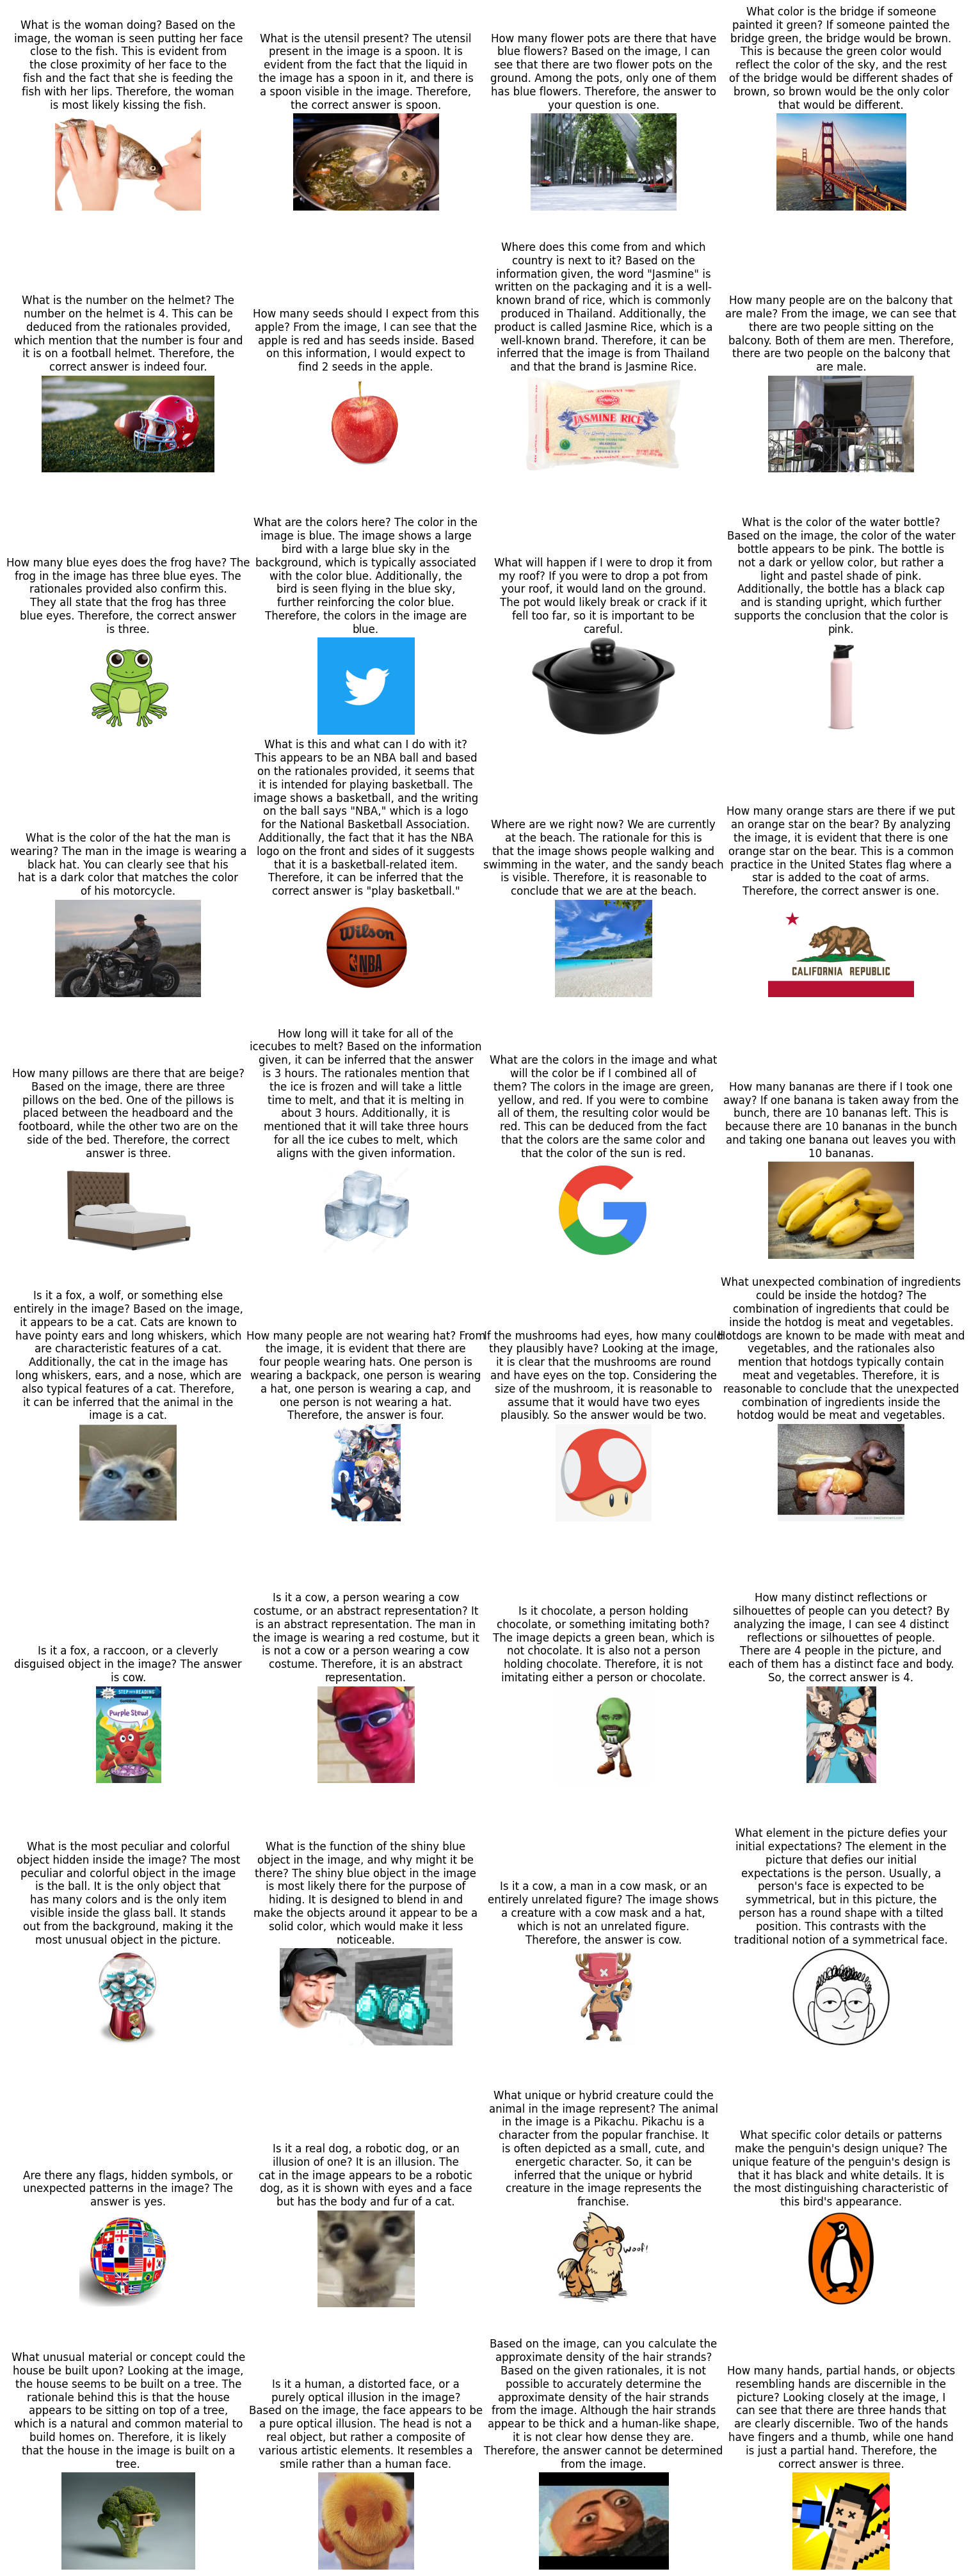

In [17]:
import matplotlib.pyplot as plt
import math
import textwrap
def plot_images_with_captions(images, captions, wrap_width=42):
    # Calculate the number of rows needed
    num_images = len(images)
    num_columns = 4
    num_rows = math.ceil(num_images / num_columns)
    
    # Create a figure with specified size
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 4))
    axes = axes.flatten()

    for idx, (image, caption) in enumerate(zip(images, captions)):
        axes[idx].imshow(image)
        # Use textwrap to wrap the caption
        wrapped_caption = "\n".join(textwrap.wrap(caption, wrap_width))
        axes[idx].set_title(wrapped_caption, fontsize=12)
        axes[idx].axis('off')

    # Turn off any extra axes
    for ax in axes[num_images:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()
plot_images_with_captions(images, qa)